In [1]:
import geopandas as gpd
import matplotlib as plt
import pandas as pd
import os
import numpy as np
from sklearn.calibration import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from shapely.geometry import Point
import mapclassify as mc
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import metrics

import seaborn as sns
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 160
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import mapclassify as mc
from sklearn.preprocessing import OrdinalEncoder, StandardScaler,OneHotEncoder
# suppress warnings
import warnings
warnings.filterwarnings('ignore')
import torch 
## print all columns in df
pd.set_option('display.max_columns', None)
#fix sklearn seed
np.random.seed(0)

In [10]:
mortgate_rate=pd.read_csv('./data/MORTGAGE30US.csv')
mortgate_rate['DATE']=pd.to_datetime(mortgate_rate['DATE'])

In [15]:
mortgate_rate.head()

,MORTGAGE30US
DATE,
2018-11-01,4.83
2018-11-08,4.94
2018-11-15,4.94
2018-11-21,4.81
2018-11-29,4.81


In [12]:
mortgate_rate.set_index('DATE',inplace=True)

<Axes: xlabel='DATE'>

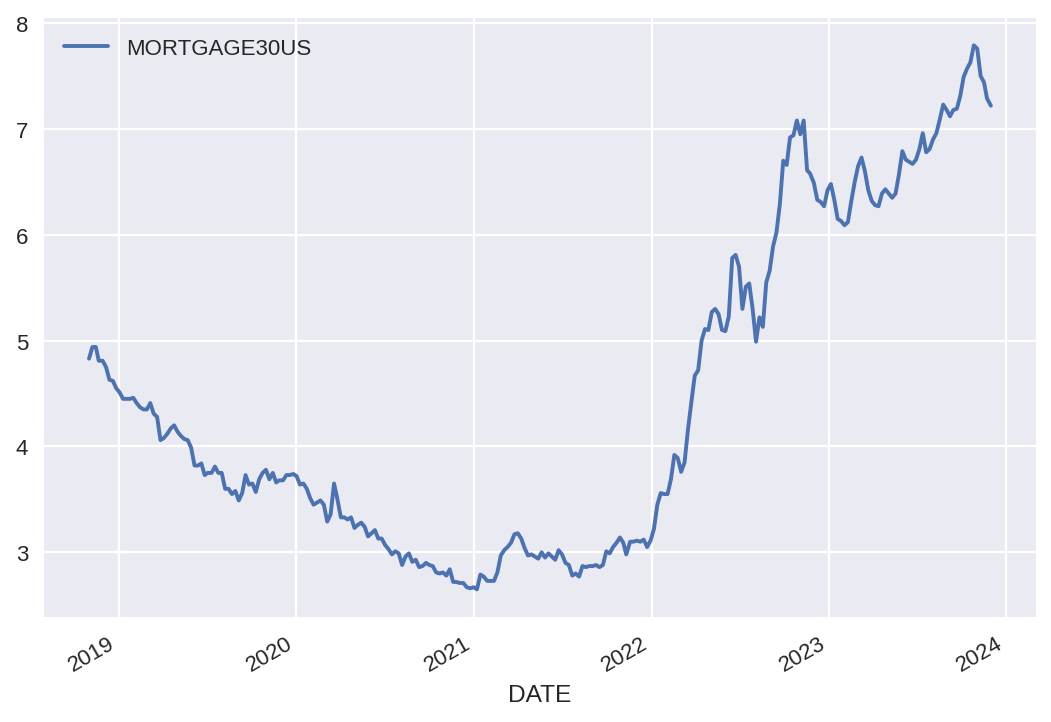

In [14]:
mortgate_rate.plot()

In [21]:
mortgate_rate=mortgate_rate.resample('D').fillna(method='ffill')

In [22]:
mortgate_rate.head()

,MORTGAGE30US
DATE,
2018-11-01,4.83
2018-11-02,4.83
2018-11-03,4.83
2018-11-04,4.83
2018-11-05,4.83


In [27]:
fn='./data/sold_chicago_5yrs_cleaned.csv'
sold=pd.read_csv(fn)

In [28]:
sold['SOLD DATE']=pd.to_datetime(sold['SOLD DATE'])
sold=sold.merge(mortgate_rate,how='left',left_on='SOLD DATE',right_on='DATE')

In [29]:
sold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128805 entries, 0 to 128804
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   SOLD DATE           128805 non-null  datetime64[ns]
 1   PROPERTY TYPE       128805 non-null  object        
 2   CITY                128805 non-null  object        
 3   STATE OR PROVINCE   128805 non-null  object        
 4   ZIP OR POSTAL CODE  128804 non-null  float64       
 5   PRICE               128805 non-null  float64       
 6   BEDS                126791 non-null  float64       
 7   BATHS               126720 non-null  float64       
 8   SQUARE FEET         85510 non-null   float64       
 9   LOT SIZE            52981 non-null   float64       
 10  YEAR BUILT          113701 non-null  float64       
 11  DAYS ON MARKET      0 non-null       float64       
 12  $/SQUARE FEET       85475 non-null   float64       
 13  HOA/MONTH           66206 non

In [64]:
sold[['PRICE','PROPERTY TYPE']].groupby('PROPERTY TYPE').max()

,PRICE
PROPERTY TYPE,
Condo/Co-op,20565240.0
Multi-Family (2-4 Unit),3950000.0
Multi-Family (5+ Unit),7800000.0
Other,1805000.0
Parking,907966.0
Single Family Residential,12550000.0
Townhouse,3900000.0
Vacant Land,8000000.0


In [62]:
sold.describe()

,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,MORTGAGE30US
count,128804.000000,1.288050e+05,126791.000000,126720.000000,85510.000000,5.298100e+04,113701.000000,0.0,85475.000000,66206.000000,128805.000000,128805.000000,128805.000000
mean,60630.554051,4.291507e+05,3.302798,2.209284,1695.187990,1.364127e+05,1957.040976,NaN,313.063387,515.663157,41.880548,-87.676214,4.319307
std,101.089022,4.271432e+05,2.317685,1.370685,1063.024936,6.912147e+06,41.253059,NaN,5342.703075,562.862973,0.085370,0.058831,1.493857
min,60005.000000,1.000000e+00,0.000000,0.500000,0.000000,1.000000e+00,1025.000000,NaN,0.000000,1.000000,41.646943,-87.939680,2.650000
25%,60614.000000,2.199000e+05,2.000000,1.500000,1077.000000,3.123000e+03,1921.000000,NaN,163.000000,244.000000,41.814523,-87.710059,3.010000
50%,60629.000000,3.299000e+05,3.000000,2.000000,1400.000000,3.750000e+03,1957.000000,NaN,237.000000,371.000000,41.900922,-87.663868,3.730000
75%,60644.000000,5.020000e+05,4.000000,2.500000,2000.000000,4.500000e+03,2001.000000,NaN,319.000000,614.000000,41.943844,-87.636679,5.510000
max,93535.000000,2.056524e+07,96.000000,84.000000,99999.000000,1.199912e+09,2023.000000,NaN,985000.000000,38010.000000,42.019314,-87.524822,7.790000


In [49]:
sold.loc[sold['PROPERTY TYPE']=='Co-op','PROPERTY TYPE']='Condo/Co-op'

In [51]:
sold.loc[sold['PROPERTY TYPE']=='Ranch','PROPERTY TYPE']='Other'

In [55]:
sold.loc[sold['PROPERTY TYPE']=='Unknown','PROPERTY TYPE']='Other'

In [54]:
sold.loc[sold['PROPERTY TYPE']=='Mobile/Manufactured Home','PROPERTY TYPE']='Other'

In [69]:
(62146+42155+16637+4920)/128804

0.9771280395018789

In [527]:
def time_series_trend(sold):
    plt.figure(figsize=(8, 3))
    # analyze the temporal trend in sold data
    # filter the sold data with 'PROPERTY TYPE'=='Condo/Co-op'
    condo=sold[sold['PROPERTY TYPE']=='Condo/Co-op']
    # filter the sold data with 'PROPERTY TYPE'=='Single Family Residential'
    single_family=sold[sold['PROPERTY TYPE']=='Single Family Residential']
    # filter the sold data with 'PROPERTY TYPE'=='Multi-Family (2-4 Unit)'
    multi_family=sold[sold['PROPERTY TYPE']=='Multi-Family (2-4 Unit)']
    
    townhouse=sold[sold['PROPERTY TYPE']=='Townhouse']
    # group 'PRICE' by 'SOLD DATE' for conda, single_family and towhouse
    condo_price=condo.groupby('SOLD DATE')['PRICE'].mean().reset_index()
    # convert the 'SOLE DATE' to float
    condo_price['SOLD DATE']=condo_price['SOLD DATE'].dt.year+condo_price['SOLD DATE'].dt.month/12
    single_family_price=single_family.groupby('SOLD DATE')['PRICE'].mean().reset_index()
    single_family_price['SOLD DATE']=single_family_price['SOLD DATE'].dt.year+single_family_price['SOLD DATE'].dt.month/12
    multi_family_price=multi_family.groupby('SOLD DATE')['PRICE'].mean().reset_index()
    multi_family_price['SOLD DATE']=multi_family_price['SOLD DATE'].dt.year+multi_family_price['SOLD DATE'].dt.month/12
    townhouse_price=townhouse.groupby('SOLD DATE')['PRICE'].mean().reset_index()
    townhouse_price['SOLD DATE']=townhouse_price['SOLD DATE'].dt.year+townhouse_price['SOLD DATE'].dt.month/12
    
    #linear_coeff
    linear_coeff(single_family_price)
    
    # plot the trend for each type
    sns.regplot(data=townhouse_price,x='SOLD DATE',y='PRICE', label=f'Townhouse {linear_coeff(townhouse_price)}',marker='.')
    sns.regplot(data=multi_family_price,x='SOLD DATE',y='PRICE', label=f'Multi-Family {linear_coeff(multi_family_price)}',marker='.')
    sns.regplot(data=single_family_price,x='SOLD DATE',y='PRICE', label=f'Single-Family {linear_coeff(single_family_price)}',marker='.')
    sns.regplot(data=condo_price,x='SOLD DATE',y='PRICE',label=f'Condo {linear_coeff(condo_price)}',marker='.')
    
    plt.legend()
#     plt.show()
    plt.savefig('./figures/average_price_sold_date.png',dpi=300,bbox_inches='tight')
    
    
    

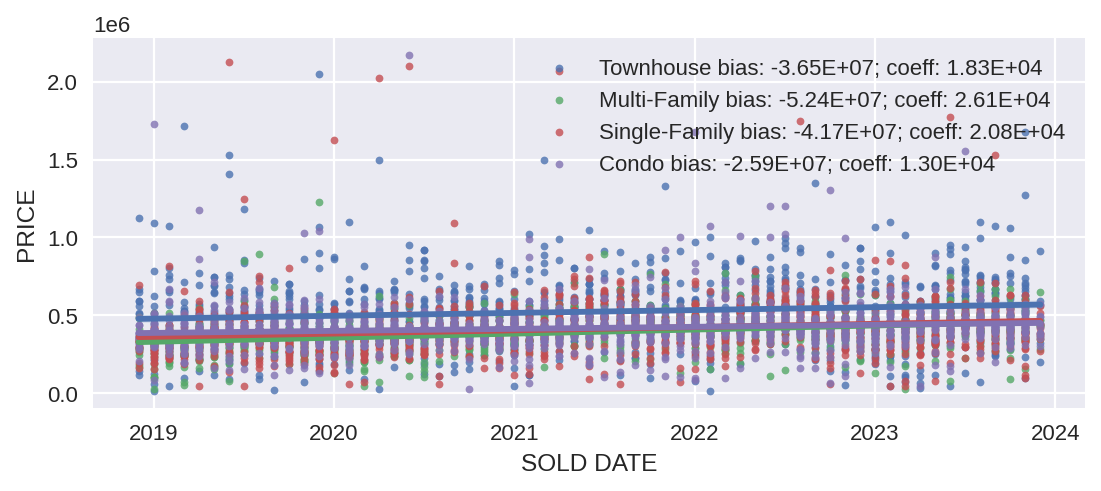

In [528]:
time_series_trend(sold)

In [91]:
def linear_coeff(df_price):
    y=df_price['PRICE'].values
    x=df_price['SOLD DATE'].values

    coeff, bias = np.polyfit(x.reshape(-1), y.reshape(-1), 1)
    return f'bias: {bias:.2E}; coeff: {coeff:.2E}'

In [530]:
sold['PRICE SQRT']=np.sqrt(sold['PRICE'])

In [537]:
sold['PROPERTY TYPE'].unique()

array(['Multi-Family (5+ Unit)', 'Condo/Co-op',
       'Single Family Residential', 'Multi-Family (2-4 Unit)', 'Other',
       'Townhouse', 'Vacant Land', 'Parking'], dtype=object)

In [536]:
t=sold.copy()

In [538]:
t.loc[t['PROPERTY TYPE']=='Condo/Co-op','PROPERTY TYPE']='Condo'

t.loc[t['PROPERTY TYPE']=='Multi-Family (5+ Unit)','PROPERTY TYPE']='MF (5+)'
t.loc[t['PROPERTY TYPE']=='Single Family Residential','PROPERTY TYPE']='SF'
t.loc[t['PROPERTY TYPE']=='Multi-Family (2-4 Unit)','PROPERTY TYPE']='MF (2-4)'
# t.loc[t['PROPERTY TYPE']=='Condo/Co-op','PROPERTY TYPE']='Condo'
# t.loc[t['PROPERTY TYPE']=='Condo/Co-op','PROPERTY TYPE']='Condo'

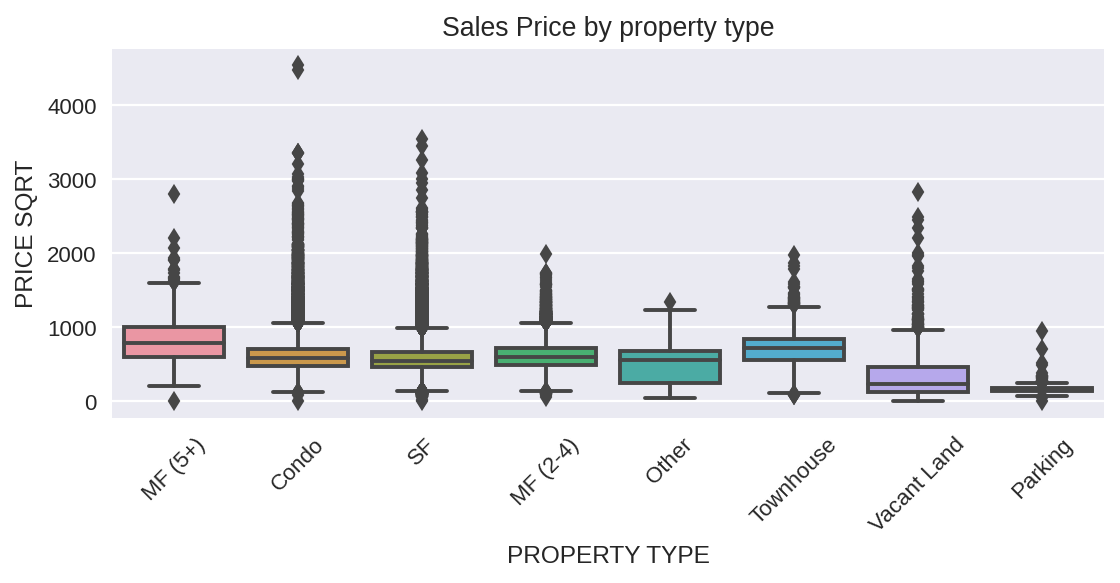

In [540]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=t,x='PROPERTY TYPE',y='PRICE SQRT')
plt.xticks(rotation=45)
plt.title('Sales Price by property type')
plt.savefig('./figures/property_price_breakdown_type_boxplot.png',dpi=300,bbox_inches='tight')

In [604]:
sold[sold['PROPERTY TYPE']=='Vacant Land'].sort_values('SOLD DATE').tail(100)
# .sort_values('PRICE')

,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,geometry,index_right,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,MAE,PRICE SQRT
56025,2023-07-26,Vacant Land,Chicago,IL,60623.0,22500.0,NaN,NaN,NaN,3750.0,NaN,NaN,NaN,NaN,41.861651,-87.712513,POINT (-87.71251 41.86165),29.0,0.0,29,29,0.0,0.0,NORTH LAWNDALE,0.0,8.948742e+07,44959.459663,79667.473261,150.000000
56368,2023-07-27,Vacant Land,Chicago,IL,60637.0,35000.0,NaN,NaN,NaN,2928.0,NaN,NaN,NaN,NaN,41.778679,-87.612337,POINT (-87.61234 41.77868),8.0,0.0,42,42,0.0,0.0,WOODLAWN,0.0,5.781518e+07,46936.959244,69486.963684,187.082869
56946,2023-07-28,Vacant Land,Chicago,IL,60612.0,110000.0,NaN,NaN,NaN,6200.0,NaN,NaN,NaN,NaN,41.876906,-87.696533,POINT (-87.69653 41.87691),27.0,0.0,27,27,0.0,0.0,EAST GARFIELD PARK,0.0,5.388322e+07,31514.625957,92772.735727,331.662479
56907,2023-07-28,Vacant Land,Chicago,IL,60618.0,820000.0,NaN,NaN,NaN,8712.0,NaN,NaN,NaN,NaN,41.938618,-87.696979,POINT (-87.69698 41.93862),21.0,0.0,21,21,0.0,0.0,AVONDALE,0.0,5.529060e+07,34261.933404,58366.443294,905.538514
56813,2023-07-28,Vacant Land,Chicago,IL,60609.0,147500.0,NaN,NaN,NaN,2613.0,NaN,NaN,NaN,NaN,41.827118,-87.667007,POINT (-87.66701 41.82712),43.0,0.0,59,59,0.0,0.0,MCKINLEY PARK,0.0,3.943180e+07,26014.096837,42383.581667,384.057287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,2023-10-31,Vacant Land,Chicago,IL,60624.0,10000.0,NaN,NaN,NaN,3125.0,NaN,NaN,NaN,NaN,41.879996,-87.726862,POINT (-87.72686 41.88000),26.0,0.0,26,26,0.0,0.0,WEST GARFIELD PARK,0.0,3.609285e+07,26238.541980,65045.827172,100.000000
106668,2023-11-06,Vacant Land,Chicago,IL,60636.0,10000.0,NaN,NaN,NaN,3125.0,NaN,NaN,NaN,NaN,41.766291,-87.672627,POINT (-87.67263 41.76629),64.0,0.0,67,67,0.0,0.0,WEST ENGLEWOOD,0.0,8.794769e+07,40195.203307,44625.463983,100.000000
106899,2023-11-07,Vacant Land,Chicago,IL,60651.0,30000.0,NaN,NaN,NaN,3049.0,NaN,NaN,NaN,NaN,41.900331,-87.719821,POINT (-87.71982 41.90033),23.0,0.0,23,23,0.0,0.0,HUMBOLDT PARK,0.0,1.004809e+08,48583.064330,68115.829105,173.205081
107212,2023-11-08,Vacant Land,Chicago,IL,60639.0,66600.0,NaN,NaN,NaN,3049.0,NaN,NaN,NaN,NaN,41.926719,-87.775594,POINT (-87.77559 41.92672),18.0,0.0,19,19,0.0,0.0,BELMONT CRAGIN,0.0,1.090994e+08,43311.707379,42793.796840,258.069758


In [602]:
sold[sold['PROPERTY TYPE']=='Vacant Land']['PRICE'].count()

1304

In [144]:
import utils

In [149]:
fn='./data/sold_chicago_5yrs_sample_bytypes.csv'
sold=pd.read_csv(fn)
# convert column sold date to datetime
sold['SOLD DATE']=pd.to_datetime(sold['SOLD DATE'])

mortgate_rate=pd.read_csv('./data/MORTGAGE30US.csv')
mortgate_rate['DATE']=pd.to_datetime(mortgate_rate['DATE'])
mortgate_rate.set_index('DATE',inplace=True)
# mortgate_rate is weekly, backfill to daily
mortgate_rate=mortgate_rate.resample('D').fillna(method='ffill')
# create a column mortgate_rate_date, which is the 1 month before sold date
sold['mortgate_rate_date']=sold['SOLD DATE']-pd.DateOffset(months=1)
# join the mortgate rate to sold data by date
sold=sold.merge(mortgate_rate,how='left',left_on='mortgate_rate_date',right_on='DATE')
# remove the duplicate records
# sold.drop_duplicates(inplace=True)
# CAP the mortgate rate to 5%
# sold.loc[sold['MORTGAGE30US']>6,'MORTGAGE30US']=6
# over sample the 2022 data
# sold=sold.append([sold[sold['SOLD DATE'].dt.year==2022]]*2,ignore_index=True)
# sort the sold data by sold date
sold=sold.sort_values(by='SOLD DATE')
sold['YEAR BUILT']=2023-sold['YEAR BUILT']
# fill missing value with 0
sold=sold.fillna(0)
sold.loc[:,'SOLD YEAR Trans']=sold['SOLD DATE'].dt.year
sold.loc[:,'SOLD DATE Trans']=sold['SOLD DATE'].dt.month/12+sold['SOLD DATE'].dt.year
# get day of the week
sold.loc[:,'SOLD DAY OF WEEK']=sold['SOLD DATE'].dt.dayofweek
# PCA on the lat and lon to get 1d
pca = PCA(n_components=1)
pca.fit(sold[['LONGITUDE','LATITUDE']])
sold['PCA']=pca.transform(sold[['LONGITUDE','LATITUDE']])
sold['PRICE_TARGET']=sold['PRICE']

sold_test=sold[sold['SOLD DATE']>=pd.Timestamp(2023,8,1)]

In [150]:
sold_test.shape

(6882, 23)

In [155]:
sold_test

,Unnamed: 0,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,mortgate_rate_date,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,pred
0,6402,2023-08-01,Condo/Co-op,Chicago,IL,60611.0,680000.0,2.0,2.0,1185.0,0.0,16.0,0.0,574.0,1033.0,41.892874,-87.620760,2023-07-01,6.71,2023,2023.666667,1,0.005358,680000.0,683450.80
1,14494,2023-08-01,Condo/Co-op,Chicago,IL,60649.0,60000.0,2.0,1.0,611.0,0.0,83.0,0.0,98.0,661.0,41.763318,-87.558357,2023-07-01,6.71,2023,2023.666667,1,0.149073,60000.0,69390.96
2,13870,2023-08-01,Condo/Co-op,Chicago,IL,60610.0,144200.0,0.0,1.0,525.0,0.0,59.0,0.0,275.0,654.0,41.905459,-87.629626,2023-07-01,6.71,2023,2023.666667,1,-0.009732,144200.0,148516.23
3,1640,2023-08-01,Condo/Co-op,Chicago,IL,60613.0,355000.0,2.0,2.0,1300.0,0.0,105.0,0.0,273.0,559.0,41.948084,-87.646074,2023-07-01,6.71,2023,2023.666667,1,-0.055372,355000.0,352628.88
4,12174,2023-08-01,Condo/Co-op,Chicago,IL,60614.0,233000.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,590.0,41.924259,-87.637924,2023-07-01,6.71,2023,2023.666667,1,-0.030282,233000.0,322450.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,11168,2023-11-13,Condo/Co-op,Chicago,IL,60605.0,280000.0,1.0,1.0,830.0,0.0,19.0,0.0,337.0,449.0,41.861817,-87.627037,2023-10-13,7.57,2023,2023.916667,0,0.031259,280000.0,273090.94
6878,8986,2023-11-13,Condo/Co-op,Chicago,IL,60613.0,406500.0,2.0,2.0,1400.0,0.0,122.0,0.0,290.0,412.0,41.955377,-87.650133,2023-10-13,7.57,2023,2023.916667,0,-0.063683,406500.0,398867.28
6879,13014,2023-11-13,Condo/Co-op,Chicago,IL,60610.0,190000.0,1.0,1.0,820.0,0.0,55.0,0.0,232.0,934.0,41.908092,-87.631220,2023-10-13,7.57,2023,2023.916667,0,-0.012784,190000.0,189186.50
6880,6193,2023-11-13,Condo/Co-op,Chicago,IL,60614.0,725000.0,3.0,2.5,2125.0,0.0,15.0,0.0,341.0,350.0,41.930649,-87.668014,2023-10-13,7.57,2023,2023.916667,0,-0.048246,725000.0,724424.70


In [153]:
sold_test=pd.read_csv('./GNN_test_result.csv')

In [159]:
sold_test['error']=sold_test['PRICE_TARGET']-sold_test['pred']
sold_test['MAE']=np.abs(sold_test['error'])
sold_test['MAPE']=sold_test['MAE']/sold_test['PRICE_TARGET']

In [185]:
sold_test[['PROPERTY TYPE','MAPE']].groupby('PROPERTY TYPE').mean()

,MAPE
PROPERTY TYPE,
Condo/Co-op,0.071356
Multi-Family (2-4 Unit),0.332328
Multi-Family (5+ Unit),0.307472
Parking,0.600546
Single Family Residential,0.075924
Townhouse,0.085466
Vacant Land,1.723808


In [172]:
sold_test.sort_values('MAE').tail()

,Unnamed: 0,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,mortgate_rate_date,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,pred,error,MAE,MAPE
5583,33296,2023-10-20,Multi-Family (5+ Unit),Chicago,IL,60649.0,575000.0,22.0,19.0,0.0,8300.0,97.0,0.0,0.0,0.0,41.756876,-87.560568,2023-09-20,7.18,2023,2023.833333,4,0.154080,575000.0,1550840.80,-975840.80,975840.80,1.697114
1282,32594,2023-08-18,Multi-Family (5+ Unit),Chicago,IL,60614.0,2150000.0,8.0,8.0,0.0,6250.0,54.0,0.0,0.0,0.0,41.928310,-87.651301,2023-07-18,6.96,2023,2023.666667,4,-0.039376,2150000.0,1140210.80,1009789.20,1009789.20,0.469669
6598,29263,2023-11-06,Multi-Family (2-4 Unit),Chicago,IL,60622.0,2375000.0,9.0,6.5,0.0,8500.0,133.0,0.0,0.0,0.0,41.906246,-87.676817,2023-10-06,7.49,2023,2023.916667,0,-0.029452,2375000.0,1328250.90,1046749.10,1046749.10,0.440736
119,5010,2023-08-01,Condo/Co-op,Chicago,IL,60611.0,6820000.0,4.0,5.5,0.0,0.0,45.0,0.0,0.0,6708.0,41.902639,-87.624836,2023-07-01,6.71,2023,2023.666667,1,-0.005222,6820000.0,4411027.00,2408973.00,2408973.00,0.353222
2056,38517,2023-08-29,Vacant Land,Chicago,IL,60608.0,8000000.0,0.0,0.0,0.0,233917.0,0.0,0.0,0.0,0.0,41.838349,-87.662516,2023-07-29,6.81,2023,2023.666667,1,0.038457,8000000.0,123177.46,7876822.54,7876822.54,0.984603


In [170]:
sold_test_rm_outlier=sold_test[sold_test['Unnamed: 0']!=38517]
sold_test_rm_outlier.sort_values('PRICE').tail()

,Unnamed: 0,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,mortgate_rate_date,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,pred,error,MAE,MAPE
3547,18201,2023-09-18,Single Family Residential,Chicago,IL,60613.0,5100000.0,7.0,5.5,9700.0,7697.0,18.0,0.0,526.0,0.0,41.949551,-87.666801,2023-08-18,7.09,2023,2023.750000,0,-0.065060,5100000.0,4812748.0,287252.0,287252.0,0.056324
5721,5013,2023-10-23,Condo/Co-op,Chicago,IL,60610.0,5500000.0,4.0,4.5,4776.0,0.0,5.0,0.0,1152.0,4401.0,41.899816,-87.628768,2023-09-23,7.19,2023,2023.833333,0,-0.004221,5500000.0,5581077.0,-81077.0,81077.0,0.014741
3924,669,2023-09-25,Condo/Co-op,Chicago,IL,60614.0,5950000.0,3.0,3.5,4250.0,0.0,12.0,0.0,1400.0,3950.0,41.929181,-87.639537,2023-08-25,7.23,2023,2023.750000,0,-0.035437,5950000.0,5540104.0,409896.0,409896.0,0.068890
6242,19569,2023-10-31,Single Family Residential,Chicago,IL,60614.0,6175000.0,7.0,7.0,8800.0,6120.0,0.0,0.0,702.0,0.0,41.925086,-87.641136,2023-09-30,7.31,2023,2023.833333,1,-0.032333,6175000.0,5690052.5,484947.5,484947.5,0.078534
119,5010,2023-08-01,Condo/Co-op,Chicago,IL,60611.0,6820000.0,4.0,5.5,0.0,0.0,45.0,0.0,0.0,6708.0,41.902639,-87.624836,2023-07-01,6.71,2023,2023.666667,1,-0.005222,6820000.0,4411027.0,2408973.0,2408973.0,0.353222


In [179]:
sold_test_rm_outlier.groupby('PROPERTY TYPE').mean('MAE')

,Unnamed: 0,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,pred,error,MAE,MAPE
PROPERTY TYPE,,,,,,,,,,,,,,,,,,,,,,,
Condo/Co-op,9247.500962,60626.906030,448675.312059,1.962476,1.711674,997.594291,107.158435,44.785760,0.0,227.708146,629.466966,41.912275,-87.656205,7.020847,2023.0,2023.752031,2.271007,-0.026673,448675.312059,444220.983879,4454.328180,29306.382023,0.071356
Multi-Family (2-4 Unit),30498.898002,60630.173502,432335.349106,6.120925,3.002103,30.305994,117986.291272,92.957939,0.0,1.937960,0.000000,41.855529,-87.686706,7.046593,2023.0,2023.763757,2.220820,0.012991,432335.349106,417004.127172,15331.221934,102059.388905,0.332328
Multi-Family (5+ Unit),33143.972222,60632.430556,826316.111111,17.625000,11.111111,2749.319444,5431.833333,95.708333,0.0,31.847222,0.000000,41.830990,-87.662174,7.068611,2023.0,2023.762731,2.069444,0.045330,826316.111111,787118.713194,39197.397917,210881.627639,0.307472
Parking,40105.567568,60617.621622,35136.486486,0.000000,0.000000,0.000000,155.945946,33.243243,0.0,0.000000,245.513514,41.904244,-87.632439,7.051351,2023.0,2023.761261,2.135135,-0.009752,35136.486486,37807.468459,-2670.981973,18043.798514,0.600546
Single Family Residential,21972.411243,60633.272189,438186.533390,3.748521,2.242815,1653.245562,123341.013525,73.939560,0.0,182.161031,1.364328,41.834728,-87.694910,7.035871,2023.0,2023.758629,2.309383,0.028729,438186.533390,432134.705313,6051.828077,29985.262277,0.075924
Townhouse,36479.877551,60627.518367,574923.383673,2.983673,2.455102,1494.322449,945.951020,34.048980,0.0,201.138776,248.632653,41.879746,-87.661159,7.029755,2023.0,2023.757483,2.269388,0.001110,574923.383673,564258.832253,10664.551420,34104.387682,0.085466
Vacant Land,39204.163043,60629.239130,177123.913043,0.000000,0.000000,0.000000,4644.750000,0.000000,0.0,0.000000,0.000000,41.843437,-87.674065,7.056413,2023.0,2023.766304,2.467391,0.029149,177123.913043,182214.408959,-5090.495915,113468.018128,1.731843


Text(0.5, 1.0, 'Sales Price Prediction error by property type')

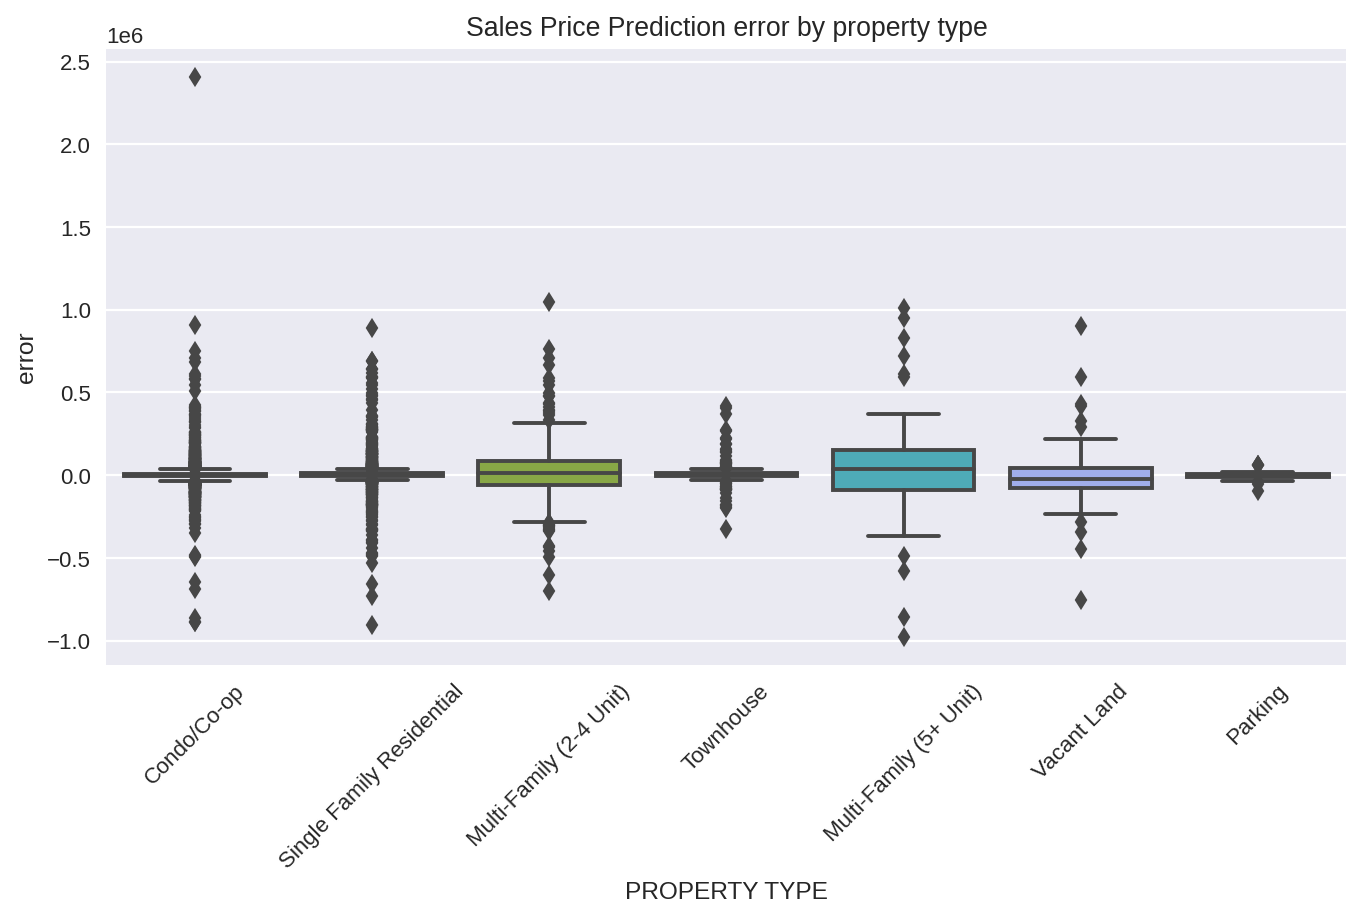

In [171]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=sold_test_rm_outlier,x='PROPERTY TYPE',y='error')
plt.xticks(rotation=45)
plt.title('Sales Price Prediction error by property type')
# plt.savefig('./figures/property_price_breakdown_type_boxplot.png',dpi=300,bbox_inches='tight')

In [186]:
sold_test

,Unnamed: 0,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,mortgate_rate_date,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,pred,error,MAE,MAPE
0,6402,2023-08-01,Condo/Co-op,Chicago,IL,60611.0,680000.0,2.0,2.0,1185.0,0.0,16.0,0.0,574.0,1033.0,41.892874,-87.620760,2023-07-01,6.71,2023,2023.666667,1,0.005358,680000.0,683450.80,-3450.80,3450.80,0.005075
1,14494,2023-08-01,Condo/Co-op,Chicago,IL,60649.0,60000.0,2.0,1.0,611.0,0.0,83.0,0.0,98.0,661.0,41.763318,-87.558357,2023-07-01,6.71,2023,2023.666667,1,0.149073,60000.0,69390.96,-9390.96,9390.96,0.156516
2,13870,2023-08-01,Condo/Co-op,Chicago,IL,60610.0,144200.0,0.0,1.0,525.0,0.0,59.0,0.0,275.0,654.0,41.905459,-87.629626,2023-07-01,6.71,2023,2023.666667,1,-0.009732,144200.0,148516.23,-4316.23,4316.23,0.029932
3,1640,2023-08-01,Condo/Co-op,Chicago,IL,60613.0,355000.0,2.0,2.0,1300.0,0.0,105.0,0.0,273.0,559.0,41.948084,-87.646074,2023-07-01,6.71,2023,2023.666667,1,-0.055372,355000.0,352628.88,2371.12,2371.12,0.006679
4,12174,2023-08-01,Condo/Co-op,Chicago,IL,60614.0,233000.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,590.0,41.924259,-87.637924,2023-07-01,6.71,2023,2023.666667,1,-0.030282,233000.0,322450.22,-89450.22,89450.22,0.383907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,11168,2023-11-13,Condo/Co-op,Chicago,IL,60605.0,280000.0,1.0,1.0,830.0,0.0,19.0,0.0,337.0,449.0,41.861817,-87.627037,2023-10-13,7.57,2023,2023.916667,0,0.031259,280000.0,273090.94,6909.06,6909.06,0.024675
6878,8986,2023-11-13,Condo/Co-op,Chicago,IL,60613.0,406500.0,2.0,2.0,1400.0,0.0,122.0,0.0,290.0,412.0,41.955377,-87.650133,2023-10-13,7.57,2023,2023.916667,0,-0.063683,406500.0,398867.28,7632.72,7632.72,0.018777
6879,13014,2023-11-13,Condo/Co-op,Chicago,IL,60610.0,190000.0,1.0,1.0,820.0,0.0,55.0,0.0,232.0,934.0,41.908092,-87.631220,2023-10-13,7.57,2023,2023.916667,0,-0.012784,190000.0,189186.50,813.50,813.50,0.004282
6880,6193,2023-11-13,Condo/Co-op,Chicago,IL,60614.0,725000.0,3.0,2.5,2125.0,0.0,15.0,0.0,341.0,350.0,41.930649,-87.668014,2023-10-13,7.57,2023,2023.916667,0,-0.048246,725000.0,724424.70,575.30,575.30,0.000794


In [407]:
boundaries_fp='./data/geo_export.shp'
boundaries=gpd.read_file(boundaries_fp)

In [245]:
df

,x,y,diff,bins
0,-87.620760,41.892874,-3450.80,3
1,-87.558357,41.763318,-9390.96,3
2,-87.629626,41.905459,-4316.23,3
3,-87.646074,41.948084,2371.12,3
4,-87.637924,41.924259,-89450.22,2
...,...,...,...,...
6877,-87.627037,41.861817,6909.06,3
6878,-87.650133,41.955377,7632.72,3
6879,-87.631220,41.908092,813.50,3
6880,-87.668014,41.930649,575.30,3


In [341]:
x_loc=sold_test['LONGITUDE'] #long
y_loc=sold_test['LATITUDE'] #lat
diff=sold_test['error']

df=pd.DataFrame({'x':x_loc,'y':y_loc,'diff':diff})
df['size']=0

In [361]:
bins=[-1e12,-1e5,-1e3,1e3,1e5,1e11]
labels=['<-100000','-100000 to -1000','-1000 to 1000','1000 to 100000','>100000']
labels_size=[5,1,0.1,1,5]

df['bins']=pd.cut(df['diff'], bins=bins, labels=labels)
df['sizes']=pd.cut(df['diff'], bins=bins, labels=labels_size,ordered=False)


In [355]:
df

,x,y,diff,size,bins,sizes
0,-87.620760,41.892874,-3450.80,0,-100000 to -1000,2.0
1,-87.558357,41.763318,-9390.96,0,-100000 to -1000,2.0
2,-87.629626,41.905459,-4316.23,0,-100000 to -1000,2.0
3,-87.646074,41.948084,2371.12,0,1000 to 100000,2.0
4,-87.637924,41.924259,-89450.22,0,-100000 to -1000,2.0
...,...,...,...,...,...,...
6877,-87.627037,41.861817,6909.06,0,1000 to 100000,2.0
6878,-87.650133,41.955377,7632.72,0,1000 to 100000,2.0
6879,-87.631220,41.908092,813.50,0,-1000 to 1000,0.1
6880,-87.668014,41.930649,575.30,0,-1000 to 1000,0.1


In [353]:
categories

CategoricalIndex(['-100000 to -1000', '1000 to 100000', '>100000', '<-100000',
                  '-1000 to 1000'],
                 categories=['<-100000', '-100000 to -1000', '-1000 to 1000', '1000 to 100000', '>100000'], ordered=True, dtype='category')

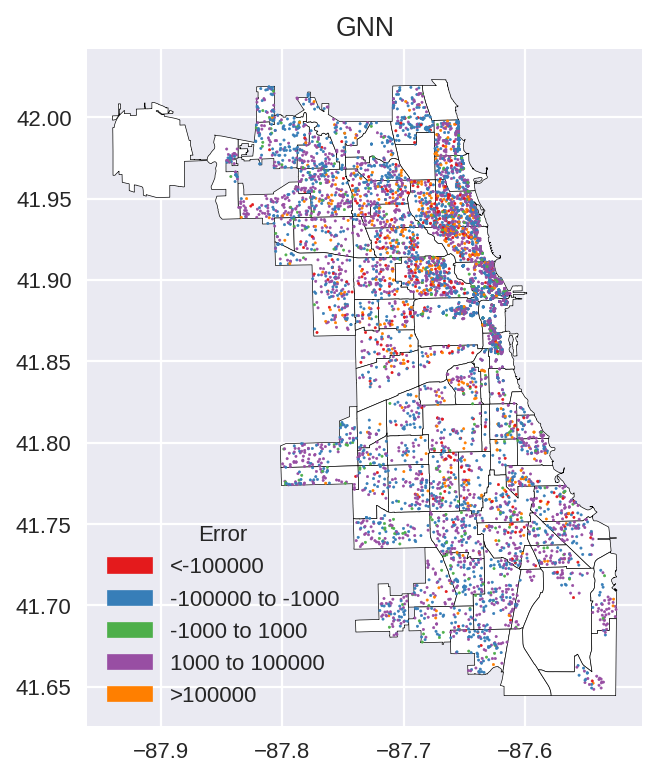

<Figure size 2400x800 with 0 Axes>

In [373]:
import matplotlib.patches
fig,ax=plt.subplots()
plt.figure(figsize=(15,5))
boundaries.plot(ax=ax,figsize=(15,15),color='white',edgecolor='black')

levels, categories = pd.factorize(df['bins'],sort=True)
colors = [plt.cm.Set1(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.Set1(i), label=c) for i, c in enumerate(categories)]

ax.scatter(df['x'], df['y'], c=colors,s=1)
ax.set_title('GNN')
# plt.gca().set(xlabel='lon', ylabel='lat', title='Petal Width vs Length')
ax.legend(handles=handles, title='Error')
# ax.legend()
fig.savefig(f'./figures/GNN_scatter_test_result_color_by_error.png',bbox_inches='tight',dpi=300)
plt.show()

In [374]:
sold_test['geometry'] = sold_test.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
sold_test_g = GeoDataFrame(sold_test, geometry='geometry')

In [375]:
sold_test_g=gpd.sjoin(sold_test_g,boundaries,how='left',op='within')

In [420]:
sold_test_g_sf_condo_th=sold_test_g[np.logical_or (\
    np.logical_or( \
    sold_test_g['PROPERTY TYPE']=='Condo/Co-op',sold_test_g['PROPERTY TYPE']=='Single Family Residential')
                                      ,sold_test_g['PROPERTY TYPE']=='Townhouse')
                                   ]

In [424]:
boundaries=boundaries.merge(sold_test_g.groupby('community')['MAE'].mean().reset_index(),on='community',how='left')

In [422]:
boundaries_3=\
boundaries.merge(sold_test_g_sf_condo_th.groupby('community')['MAE'].mean().reset_index(),on='community',how='left')

In [421]:
sold_test_g_sf_condo_th

,Unnamed: 0,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,mortgate_rate_date,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,pred,error,MAE,MAPE,geometry,index_right,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len
0,6402,2023-08-01,Condo/Co-op,Chicago,IL,60611.0,680000.0,2.0,2.0,1185.0,0.0,16.0,0.0,574.0,1033.0,41.892874,-87.620760,2023-07-01,6.71,2023,2023.666667,1,0.005358,680000.0,683450.80,-3450.80,3450.80,0.005075,POINT (-87.62076 41.89287),36.0,0.0,8,8,0.0,0.0,NEAR NORTH SIDE,0.0,7.667590e+07,57293.164952
1,14494,2023-08-01,Condo/Co-op,Chicago,IL,60649.0,60000.0,2.0,1.0,611.0,0.0,83.0,0.0,98.0,661.0,41.763318,-87.558357,2023-07-01,6.71,2023,2023.666667,1,0.149073,60000.0,69390.96,-9390.96,9390.96,0.156516,POINT (-87.55836 41.76332),38.0,0.0,43,43,0.0,0.0,SOUTH SHORE,0.0,8.181272e+07,44249.646117
2,13870,2023-08-01,Condo/Co-op,Chicago,IL,60610.0,144200.0,0.0,1.0,525.0,0.0,59.0,0.0,275.0,654.0,41.905459,-87.629626,2023-07-01,6.71,2023,2023.666667,1,-0.009732,144200.0,148516.23,-4316.23,4316.23,0.029932,POINT (-87.62963 41.90546),36.0,0.0,8,8,0.0,0.0,NEAR NORTH SIDE,0.0,7.667590e+07,57293.164952
3,1640,2023-08-01,Condo/Co-op,Chicago,IL,60613.0,355000.0,2.0,2.0,1300.0,0.0,105.0,0.0,273.0,559.0,41.948084,-87.646074,2023-07-01,6.71,2023,2023.666667,1,-0.055372,355000.0,352628.88,2371.12,2371.12,0.006679,POINT (-87.64607 41.94808),44.0,0.0,6,6,0.0,0.0,LAKE VIEW,0.0,8.721480e+07,51973.096868
4,12174,2023-08-01,Condo/Co-op,Chicago,IL,60614.0,233000.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,590.0,41.924259,-87.637924,2023-07-01,6.71,2023,2023.666667,1,-0.030282,233000.0,322450.22,-89450.22,89450.22,0.383907,POINT (-87.63792 41.92426),67.0,0.0,7,7,0.0,0.0,LINCOLN PARK,0.0,8.831640e+07,49478.427771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,11168,2023-11-13,Condo/Co-op,Chicago,IL,60605.0,280000.0,1.0,1.0,830.0,0.0,19.0,0.0,337.0,449.0,41.861817,-87.627037,2023-10-13,7.57,2023,2023.916667,0,0.031259,280000.0,273090.94,6909.06,6909.06,0.024675,POINT (-87.62704 41.86182),33.0,0.0,33,33,0.0,0.0,NEAR SOUTH SIDE,0.0,4.976964e+07,45053.165104
6878,8986,2023-11-13,Condo/Co-op,Chicago,IL,60613.0,406500.0,2.0,2.0,1400.0,0.0,122.0,0.0,290.0,412.0,41.955377,-87.650133,2023-10-13,7.57,2023,2023.916667,0,-0.063683,406500.0,398867.28,7632.72,7632.72,0.018777,POINT (-87.65013 41.95538),30.0,0.0,3,3,0.0,0.0,UPTOWN,0.0,6.509564e+07,46972.794555
6879,13014,2023-11-13,Condo/Co-op,Chicago,IL,60610.0,190000.0,1.0,1.0,820.0,0.0,55.0,0.0,232.0,934.0,41.908092,-87.631220,2023-10-13,7.57,2023,2023.916667,0,-0.012784,190000.0,189186.50,813.50,813.50,0.004282,POINT (-87.63122 41.90809),36.0,0.0,8,8,0.0,0.0,NEAR NORTH SIDE,0.0,7.667590e+07,57293.164952
6880,6193,2023-11-13,Condo/Co-op,Chicago,IL,60614.0,725000.0,3.0,2.5,2125.0,0.0,15.0,0.0,341.0,350.0,41.930649,-87.668014,2023-10-13,7.57,2023,2023.916667,0,-0.048246,725000.0,724424.70,575.30,575.30,0.000794,POINT (-87.66801 41.93065),67.0,0.0,7,7,0.0,0.0,LINCOLN PARK,0.0,8.831640e+07,49478.427771


In [423]:
boundaries_3.sort_values('MAE')

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,MAE
68,0.0,70,70,0.0,0.0,ASHBURN,0.0,1.354603e+08,54818.154632,"POLYGON ((-87.71255 41.75734, -87.71252 41.757...",6171.826118
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801...",6251.836000
65,0.0,68,68,0.0,0.0,ENGLEWOOD,0.0,8.565232e+07,42316.844297,"POLYGON ((-87.62826 41.78316, -87.62826 41.783...",6317.273417
40,0.0,45,45,0.0,0.0,AVALON PARK,0.0,3.485274e+07,27630.822534,"POLYGON ((-87.58566 41.75150, -87.58475 41.750...",7040.272346
49,0.0,51,51,0.0,0.0,SOUTH DEERING,0.0,3.037971e+08,80389.871800,"POLYGON ((-87.54568 41.72282, -87.54559 41.722...",7281.095217
...,...,...,...,...,...,...,...,...,...,...,...
47,0.0,5,5,0.0,0.0,NORTH CENTER,0.0,5.705417e+07,31391.669754,"POLYGON ((-87.67336 41.93234, -87.67342 41.932...",70539.084661
67,0.0,7,7,0.0,0.0,LINCOLN PARK,0.0,8.831640e+07,49478.427771,"POLYGON ((-87.63182 41.93258, -87.63182 41.932...",77632.203272
5,0.0,4,4,0.0,0.0,LINCOLN SQUARE,0.0,7.135233e+07,36624.603085,"POLYGON ((-87.67441 41.97610, -87.67440 41.976...",NaN
9,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",NaN


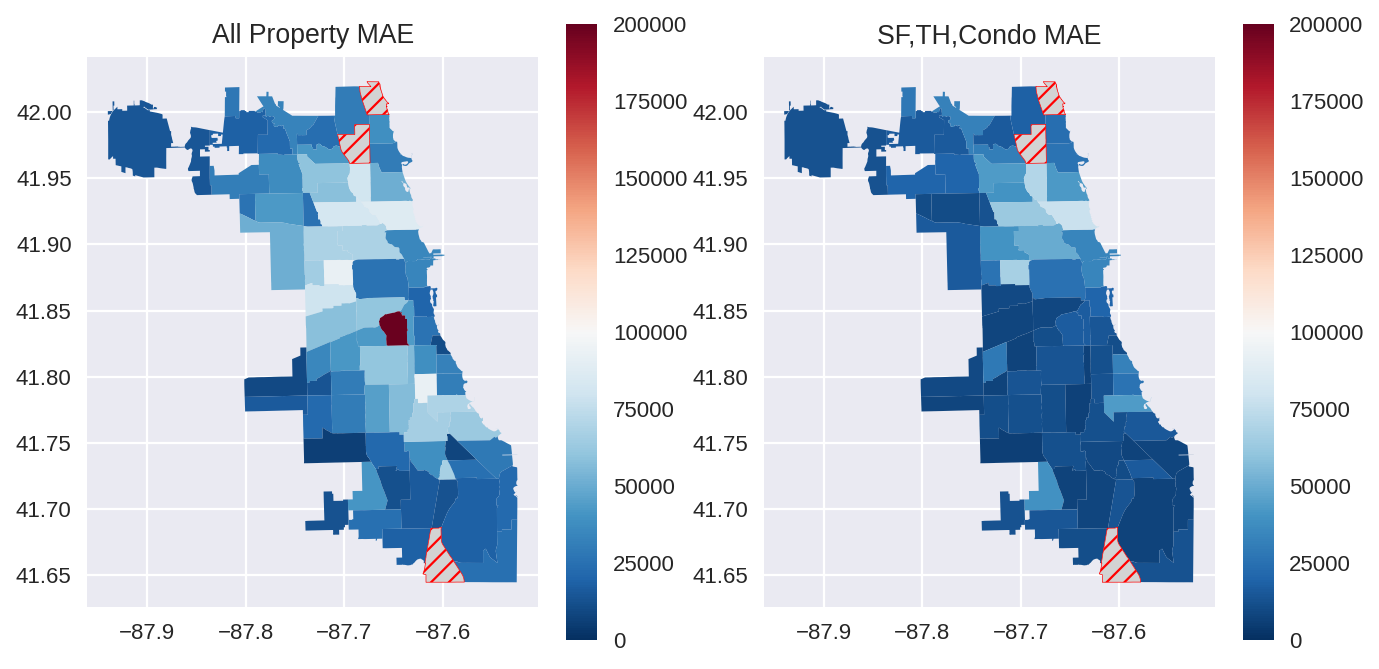

In [455]:
# boundaries.plot(column='MAE',legend=True,figsize=(10,10),cmap='coolwarm')
# plt.savefig(f'./figures/GNN_cca_error.png',bbox_inches='tight',dpi=300)
fig, ax = plt.subplots(1, 2,figsize=(10,5))
ax = np.ravel(ax)
# fix color bar range for all subplots
vmin=0
vmax=2e5
missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    }
boundaries.plot(ax=ax[0], column='MAE',legend=True,
                cmap='RdBu_r',vmin=vmin,vmax=vmax,missing_kwds=missing_kwds,)
#                 legend_kwds={'orientation':'horizontal'})
ax[0].set_title('All Property MAE')
boundaries_3.plot(ax=ax[1], column='MAE',legend=True,
                cmap='RdBu_r',vmin=vmin,vmax=vmax,missing_kwds=missing_kwds)
ax[1].set_title('SF,TH,Condo MAE')

plt.savefig(f'./figures/GNN_cca_error.png',bbox_inches='tight',dpi=300)

In [390]:
boundaries.sort_values('MAE')

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,MAE
68,0.0,70,70,0.0,0.0,ASHBURN,0.0,1.354603e+08,54818.154632,"POLYGON ((-87.71255 41.75734, -87.71252 41.757...",6214.676628
40,0.0,45,45,0.0,0.0,AVALON PARK,0.0,3.485274e+07,27630.822534,"POLYGON ((-87.58566 41.75150, -87.58475 41.750...",8086.157179
54,0.0,56,56,0.0,0.0,GARFIELD RIDGE,0.0,1.178908e+08,60080.447970,"POLYGON ((-87.73856 41.81871, -87.73853 41.818...",10082.123608
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816...",10312.460000
71,0.0,73,73,0.0,0.0,WASHINGTON HEIGHTS,0.0,7.963575e+07,42222.598163,"POLYGON ((-87.63373 41.72885, -87.63369 41.726...",12243.447641
...,...,...,...,...,...,...,...,...,...,...,...
27,0.0,27,27,0.0,0.0,EAST GARFIELD PARK,0.0,5.388322e+07,31514.625957,"POLYGON ((-87.69157 41.88820, -87.68968 41.888...",92772.735727
57,0.0,60,60,0.0,0.0,BRIDGEPORT,0.0,5.829152e+07,32732.718327,"POLYGON ((-87.63396 41.82361, -87.63409 41.823...",198875.941814
5,0.0,4,4,0.0,0.0,LINCOLN SQUARE,0.0,7.135233e+07,36624.603085,"POLYGON ((-87.67441 41.97610, -87.67440 41.976...",NaN
9,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",NaN


In [395]:
bridgeport=sold_test_g[sold_test_g['community']=='BRIDGEPORT']

In [398]:
temp=bridgeport.sort_values('MAE')[:-1]

In [399]:
temp['MAE'].mean()

66497.55218965518

In [462]:
fn='./data/sold_chicago_5yrs_cleaned.csv'
sold=pd.read_csv(fn)
sold['SOLD DATE']=pd.to_datetime(sold['SOLD DATE'])
sold

,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
0,2019-04-01,Multi-Family (5+ Unit),Chicago,IL,60629.0,430000.0,12.0,13.0,NaN,7500.0,1920.0,NaN,NaN,NaN,41.761204,-87.684733
1,2019-04-01,Condo/Co-op,Chicago,IL,60656.0,106000.0,1.0,1.0,735.0,18750.0,1978.0,NaN,144.0,115.0,41.972432,-87.845114
2,2019-04-01,Condo/Co-op,Chicago,IL,60661.0,345000.0,1.0,1.5,1060.0,NaN,2006.0,NaN,325.0,720.0,41.886072,-87.643159
3,2019-04-01,Condo/Co-op,Chicago,IL,60607.0,285000.0,1.0,1.5,1000.0,NaN,NaN,NaN,285.0,355.0,41.876869,-87.649292
4,2019-04-01,Condo/Co-op,Chicago,IL,60611.0,500000.0,1.0,1.5,1004.0,NaN,2005.0,NaN,498.0,694.0,41.894510,-87.627114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128754,2023-09-09,Multi-Family (2-4 Unit),Chicago,IL,60618.0,899000.0,8.0,5.0,NaN,NaN,1890.0,NaN,NaN,NaN,41.952017,-87.704563
128755,2023-09-09,Single Family Residential,Chicago,IL,60630.0,450000.0,3.0,2.0,1960.0,4350.0,1959.0,NaN,230.0,NaN,41.978761,-87.782002
128756,2023-09-09,Condo/Co-op,Chicago,IL,60614.0,380000.0,2.0,2.0,1100.0,NaN,NaN,NaN,345.0,1065.0,41.925498,-87.638655
128757,2023-09-09,Multi-Family (2-4 Unit),Chicago,IL,60639.0,440185.0,7.0,3.0,NaN,3484.0,1924.0,NaN,NaN,NaN,41.928827,-87.760631


In [463]:
sold.describe()

,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
count,128758.000000,1.287590e+05,126757.000000,126686.000000,85483.000000,5.297300e+04,113661.000000,0.0,85448.000000,66176.000000,128759.000000,128759.000000
mean,60630.556292,4.292483e+05,3.303052,2.209411,1695.312717,1.364332e+05,1957.033239,NaN,313.119933,515.755818,41.880547,-87.676214
std,101.106544,4.271715e+05,2.317886,1.370789,1063.124580,6.912669e+06,41.251862,NaN,5343.545806,562.869006,0.085378,0.058831
min,60005.000000,1.000000e+00,0.000000,0.500000,0.000000,1.000000e+00,1025.000000,NaN,0.000000,1.000000,41.646943,-87.939680
25%,60614.000000,2.200000e+05,2.000000,1.500000,1077.000000,3.123000e+03,1921.000000,NaN,164.000000,244.000000,41.814504,-87.710051
50%,60629.000000,3.299000e+05,3.000000,2.000000,1400.000000,3.750000e+03,1957.000000,NaN,237.000000,371.000000,41.900927,-87.663872
75%,60644.000000,5.020000e+05,4.000000,2.500000,2000.000000,4.500000e+03,2001.000000,NaN,319.000000,614.250000,41.943847,-87.636679
max,93535.000000,2.056524e+07,96.000000,84.000000,99999.000000,1.199912e+09,2023.000000,NaN,985000.000000,38010.000000,42.019314,-87.524822


In [465]:
sold['PROPERTY TYPE'].unique()

array(['Multi-Family (5+ Unit)', 'Condo/Co-op',
       'Single Family Residential', 'Multi-Family (2-4 Unit)', 'Other',
       'Townhouse', 'Vacant Land', 'Parking'], dtype=object)

In [482]:
# levels, categories = pd.factorize(df['bins'],sort=True)
property_types=['MF 5+', 'Condo',
       'SF', 'MF(2-4)', 'Other',
       'Townhouse', 'Vacant Land', 'Parking']
colors = [plt.cm.Set1(i) for i in range(8)] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.Set1(i), label=c) for i, c in enumerate(property_types)]

# ax.scatter(df['x'], df['y'], c=colors,s=1)
# ax.set_title('GNN')
# plt.gca().set(xlabel='lon', ylabel='lat', title='Petal Width vs Length')
# ax.legend(handles=handles, title='Error')

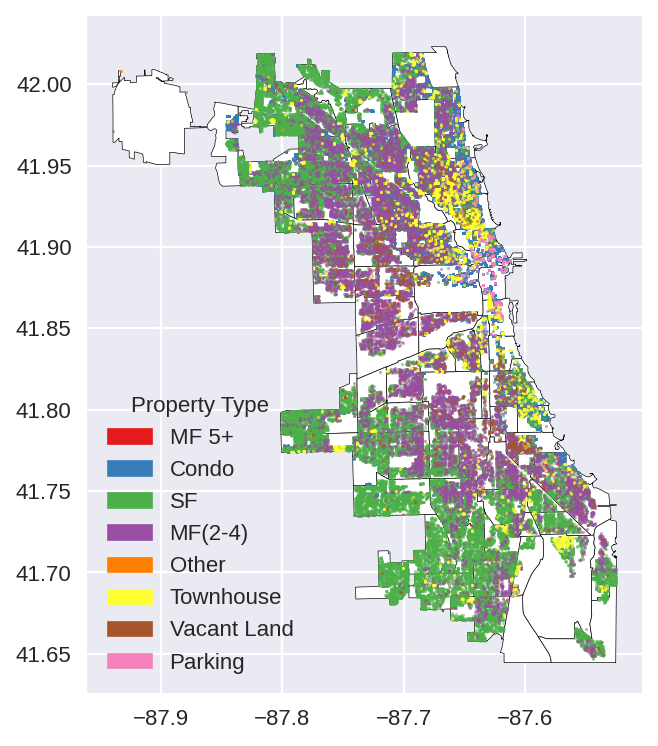

In [485]:
fig,ax=plt.subplots()

boundaries.plot(ax=ax,figsize=(45,45),color='white',edgecolor='black')
for p,c in zip(sold['PROPERTY TYPE'].unique(),colors):
    sold_p=sold[sold['PROPERTY TYPE']==p]
    ax.scatter(sold_p['LONGITUDE'],sold_p['LATITUDE'],s=1,label=p,c=c,alpha=0.5)
ax.legend(handles=handles, title='Property Type')
# levels, categories = pd.factorize(df['bins'],sort=True)
# colors = [plt.cm.Set1(i) for i in levels] # using the "tab10" colormap
# handles = [matplotlib.patches.Patch(color=plt.cm.Set1(i), label=c) for i, c in enumerate(categories)]

# ax.scatter(df['x'], df['y'], c=colors,s=1)
# ax.set_title('GNN')
# # plt.gca().set(xlabel='lon', ylabel='lat', title='Petal Width vs Length')
# ax.legend(handles=handles, title='Error')
# # ax.legend()
fig.savefig(f'./figures/chicago_sales_5years.png',bbox_inches='tight',dpi=300)
# plt.show()

In [497]:
from sklearn.model_selection import train_test_split
t=[i for i in range(10)]
train_test_split(t,shuffle=False)

[[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]

In [506]:
sold['geometry'] = sold.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
sold = GeoDataFrame(sold, geometry='geometry')
sold=gpd.sjoin(sold,boundaries,how='left',op='within')

In [516]:
single_family=sold[sold['PROPERTY TYPE']=='Single Family Residential']

In [519]:
boundaries_price=boundaries.merge(single_family.groupby('community')['PRICE'].mean().reset_index(),on='community',how='left')

In [521]:
boundaries_price=boundaries_price.set_index('community')

SVD did not converge in Linear Least Squares


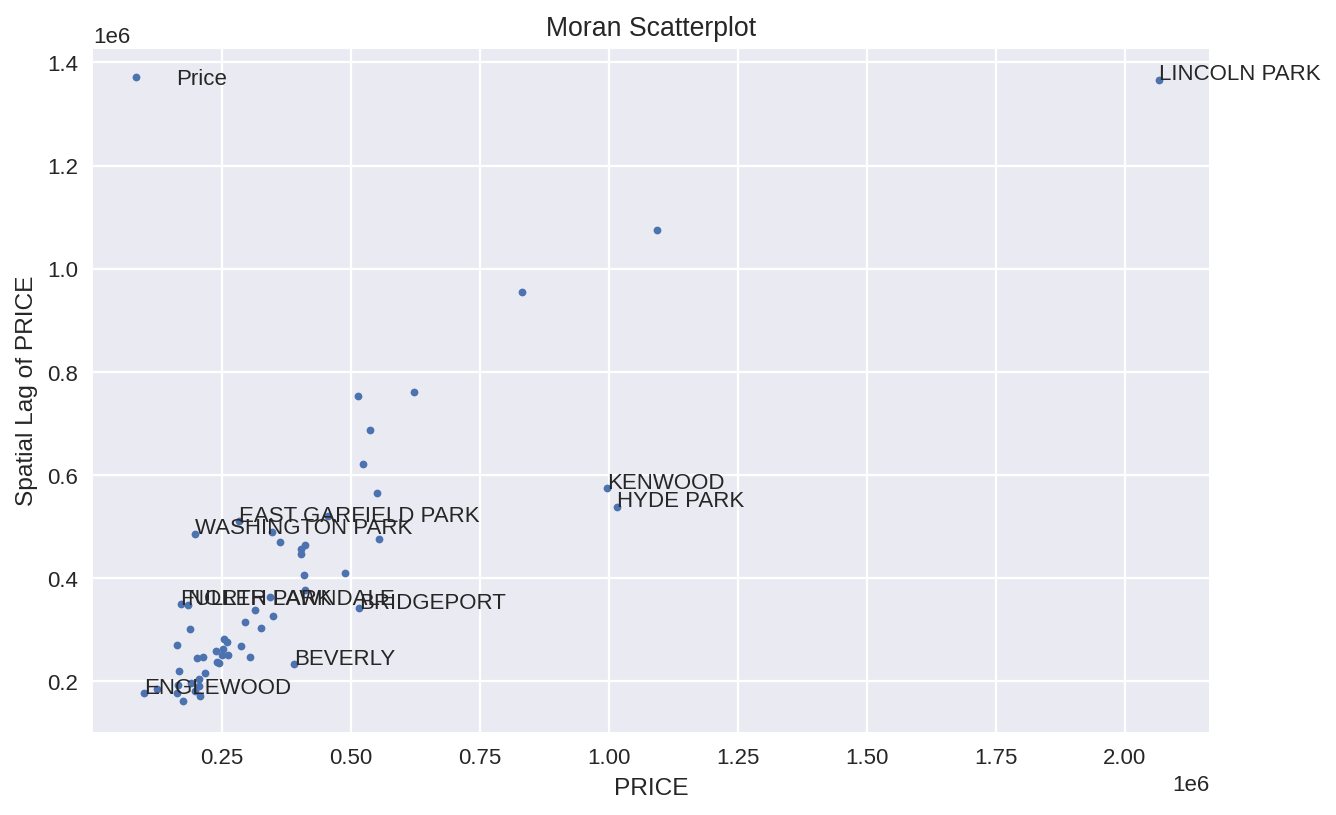

In [525]:
# spatial weights
wq =  lps.weights.Queen.from_dataframe(boundaries)
wq.transform = 'r'
moran_scatter_plot('PRICE',wq,[boundaries_price],['Price'],lable_ratio=1.5)

In [514]:
def moran_scatter_plot(sel,wq,dfs,df_names,lable_ratio=1):
    fig, ax = plt.subplots(1, figsize=(9, 9))
    already_annotated_flag=False
    for df_name, df in zip(df_names,dfs):
        y = df[sel]
        ylag=lps.weights.lag_spatial(wq,y) #apply the spatial weights on the attribute

        ax.plot(y, ylag, '.', label=df_name)
        std=np.std(1-y/ylag) #calculate the ratio of spatial autocorrelation; able the ones away from label_ratio*std
#         print(std)
        if not already_annotated_flag:
            index=0
            for name,y1,ylag1 in zip(df.index,y,ylag):
                ratio=np.abs(1-y1/ylag1)
                if ratio>lable_ratio*std:
                    ax.annotate(name,(y1,ylag1))
                index+=1
            already_annotated_flag=True
                
         # dashed vert at mean of the price
#         plt.vlines(y.mean(), ylag.min(), ylag.max(), linestyle='--')
        #  # dashed horizontal at mean of lagged price
#         plt.hlines(ylag.mean(), y.min(), y.max(), linestyle='--')

        # red line of best fit using global I as slope
        try:
            b, a = np.polyfit(y, ylag, 1)
            plt.plot(y, a + b*y, label=df_name)
        except Exception as e:
            print(e)
    # remove space and special characters in column name
    sel=sel.replace('/','').replace(' ','')
    plt.title('Moran Scatterplot')
    plt.ylabel(f'Spatial Lag of {sel}')
    plt.xlabel(f'{sel}')
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.savefig(f'./figures/moran_scatterplot_{sel}.png',dpi=300)
    plt.close

In [548]:
compare_df=pd.read_csv('./GNN_compare_df.csv')
compare_df['SOLD DATE']=pd.to_datetime(compare_df['SOLD DATE'])
compare_df['geometry'] = compare_df.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
compare_df = GeoDataFrame(compare_df, geometry='geometry')

In [556]:
pred=compare_df.iloc[-1:]

In [552]:
combo=compare_df.iloc[:5]

In [570]:
combo

,Unnamed: 0,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,mortgate_rate_date,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,geometry
0,6695,2023-07-28,Condo/Co-op,Chicago,IL,60618.0,630000.0,4.0,3.0,0.0,0.0,11.0,0.0,0.0,308.0,41.939216,-87.689276,2023-06-28,6.67,2023,2023.583333,4,-0.064648,630000.0,POINT (-87.68928 41.93922)
1,39071,2023-06-09,Vacant Land,Chicago,IL,60609.0,125000.0,0.0,0.0,0.0,3049.0,0.0,0.0,0.0,0.0,41.830164,-87.671870,2023-05-09,6.39,2023,2023.500000,4,0.042183,125000.0,POINT (-87.67187 41.83016)
2,39178,2023-03-31,Vacant Land,Chicago,IL,60608.0,175000.0,0.0,0.0,0.0,2178.0,0.0,0.0,0.0,0.0,41.843707,-87.657750,2023-02-28,6.50,2023,2023.250000,4,0.035471,175000.0,POINT (-87.65775 41.84371)
3,38959,2023-06-14,Vacant Land,Chicago,IL,60608.0,185000.0,0.0,0.0,0.0,2178.0,0.0,0.0,0.0,0.0,41.856882,-87.652596,2023-05-14,6.35,2023,2023.500000,2,0.025486,185000.0,POINT (-87.65260 41.85688)
4,38841,2023-07-14,Vacant Land,Chicago,IL,60608.0,54000.0,0.0,0.0,0.0,2178.0,0.0,0.0,0.0,0.0,41.847514,-87.679090,2023-06-14,6.71,2023,2023.583333,4,0.023395,54000.0,POINT (-87.67909 41.84751)


In [564]:
bridgeport=boundaries[boundaries['community']=='BRIDGEPORT']

In [589]:
combo

,Unnamed: 0,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,mortgate_rate_date,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,geometry
0,6695,2023-07-28,Condo/Co-op,Chicago,IL,60618.0,630000.0,4.0,3.0,0.0,0.0,11.0,0.0,0.0,308.0,41.939216,-87.689276,2023-06-28,6.67,2023,2023.583333,4,-0.064648,630000.0,POINT (-87.68928 41.93922)
1,39071,2023-06-09,Vacant Land,Chicago,IL,60609.0,125000.0,0.0,0.0,0.0,3049.0,0.0,0.0,0.0,0.0,41.830164,-87.671870,2023-05-09,6.39,2023,2023.500000,4,0.042183,125000.0,POINT (-87.67187 41.83016)
2,39178,2023-03-31,Vacant Land,Chicago,IL,60608.0,175000.0,0.0,0.0,0.0,2178.0,0.0,0.0,0.0,0.0,41.843707,-87.657750,2023-02-28,6.50,2023,2023.250000,4,0.035471,175000.0,POINT (-87.65775 41.84371)
3,38959,2023-06-14,Vacant Land,Chicago,IL,60608.0,185000.0,0.0,0.0,0.0,2178.0,0.0,0.0,0.0,0.0,41.856882,-87.652596,2023-05-14,6.35,2023,2023.500000,2,0.025486,185000.0,POINT (-87.65260 41.85688)
4,38841,2023-07-14,Vacant Land,Chicago,IL,60608.0,54000.0,0.0,0.0,0.0,2178.0,0.0,0.0,0.0,0.0,41.847514,-87.679090,2023-06-14,6.71,2023,2023.583333,4,0.023395,54000.0,POINT (-87.67909 41.84751)


In [600]:
pred

,Unnamed: 0,SOLD DATE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,mortgate_rate_date,MORTGAGE30US,SOLD YEAR Trans,SOLD DATE Trans,SOLD DAY OF WEEK,PCA,PRICE_TARGET,geometry
9,38517,2023-08-29,Vacant Land,Chicago,IL,60608.0,8000000.0,0.0,0.0,0.0,233917.0,0.0,0.0,0.0,0.0,41.838349,-87.662516,2023-07-29,6.81,2023,2023.666667,1,0.038457,8000000.0,POINT (-87.66252 41.83835)


In [591]:
combo.LONGITUDE.max()

-87.652596

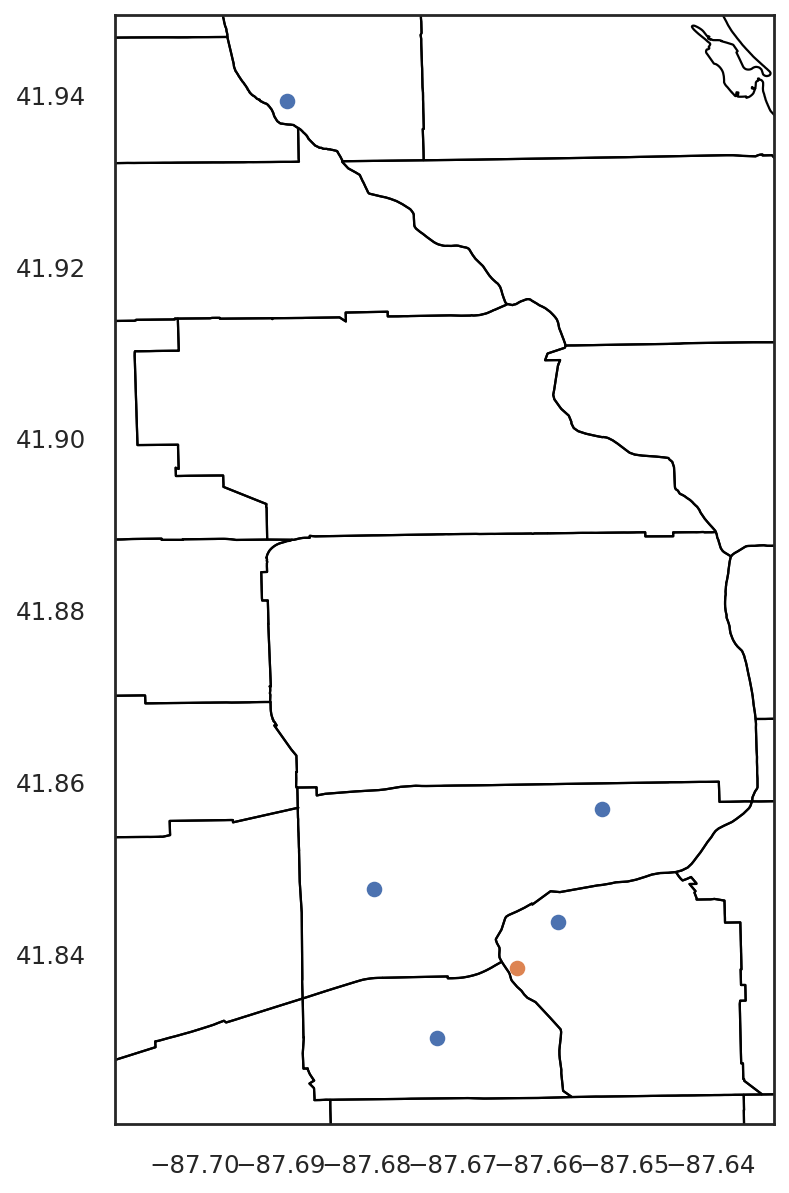

In [599]:
sns.set_theme(style='white')
fig, ax = plt.subplots(1, figsize=(9, 9))
ax.set_xlim(combo.LONGITUDE.min()-0.02,combo.LONGITUDE.max()+0.02)
ax.set_ylim(combo.LATITUDE.min()-0.01,combo.LATITUDE.max()+0.01)
boundaries.plot(ax=ax,facecolor='none',edgecolor='black')
combo.plot(ax=ax)
pred.plot(ax=ax)
plt.savefig(f'./figures/case_study.png',dpi=300)